# Underneath the Pipeline

This tutorial executes a given pipeline while also viewing the intermediate results. It can be applied to any pipeline available in the Orion repository. In this edition, we will be viewing the `tadgan` pipeline.

First let's load a demo dataset

In [1]:
from orion.data import load_signal

signal = load_signal('S-1')
signal_without_anom = load_signal('S-1-train')
signal_with_anom = load_signal('S-1-test')
signal.head()

,timestamp,value
0,1222819200,-0.366359
1,1222840800,-0.394108
2,1222862400,0.403625
3,1222884000,-0.362759
4,1222905600,-0.370746


Load the desired pipeline and setup hyperparameters as necessary

In [2]:
from mlblocks import MLPipeline

hyper = {
    "sklearn.preprocessing.MinMaxScaler#1": {
        "feature_range": [-1, 1]
    },
    "orion.primitives.tadgan.TadGAN#1": { 
        "epochs": 10, 
        "verbose": True,
        "validation_split": 0.0
    } 
}  

pipeline = MLPipeline('tadgan')
pipeline.set_hyperparameters(hyper)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Step by Step Executation

Now we view the intermediate results by looking at the context at each step. First we go through the training process, then we continue to the detection sequences.

## Training

### step 0: time_segments_aggregate

equally space the timeseries

In [3]:
step = 0
context = pipeline.fit(signal, output_=step)

In [4]:
context.keys()

dict_keys(['X', 'index'])

### step 1: SimpleImputer

impute missing values

In [5]:
step = 1
context = pipeline.fit(**context, output_=step, start_=step)

In [6]:
context.keys()

dict_keys(['index', 'X'])

### step 2: MinMaxScaler

scale the data between -1 and 1

In [7]:
step = 2
context = pipeline.fit(**context, output_=step, start_=step)

In [8]:
context.keys()

dict_keys(['index', 'X'])

### step 3: rolling_window_sequences

generate training examples from rolling window sequences

In [9]:
step = 3
context = pipeline.fit(**context, output_=step, start_=step)

In [10]:
context.keys()

dict_keys(['index', 'X', 'y', 'X_index', 'target_index'])

### step 4: TadGAN

train the TadGAN model using the generated window sequences

In [11]:
step = 4
context = pipeline.fit(**context, output_=step, start_=step)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/Users/sarah/opt/anaconda3/envs/orion/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/Users/sarah/opt/anaconda3/envs/orion/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/sarah/opt/anaconda3/envs/orion/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/sarah/opt/anaconda3/envs/orion/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1/10, [Dx loss: [-2.5895422  -5.0118747   1.4272469   0.09950858]] [Dz loss: [-1.3856504  -1.9563327  -0.59258443  0.1163267 ]] [G loss: [ 2.073715  -1.416676   1.2220567  0.2268334]]
Epoch: 2/10, [Dx loss: [-3.5973234  -5.644382    1.5419292   0.05051273]] [Dz loss: [-3.3126898 -3.2940419 -1.0770003  0.1058353]] [G loss: [ 1.9867396  -1.5085914   1.3484728   0.21468587]]
Epoch: 3/10, [Dx loss: [-3.3529928  -5.474612    1.6860714   0.04355478]] [Dz loss: [-1.9597102  -3.3116145   0.5746686   0.07772351]] [G loss: [ 0.3153107  -1.6702453  -0.19440857  0.21799648]]
Epoch: 4/10, [Dx loss: [-3.1988657  -5.2914453   1.662976    0.04296039]] [Dz loss: [-1.3683594  -1.1619302  -0.58091825  0.037449  ]] [G loss: [ 1.7359052  -1.6577837   1.1244019   0.22692868]]
Epoch: 5/10, [Dx loss: [-3.2020109  -5.1778736   1.5245775   0.04512852]] [Dz loss: [-1.3386182  -0.47125152 -1.3341565   0.04667902]] [G loss: [ 3.000364   -1.5218116   2.2113416   0.23108336]]
Epoch: 6/10, [Dx loss: [-3.189890

In [12]:
context.keys()

dict_keys(['index', 'X_index', 'target_index', 'X', 'y', 'y_hat', 'critic'])

## Detecting

We can either use another part of the signal or the same signal. If you are using the same signal, there is no reseaon to repeat step 0 - 3.

### step 0 - 3: similar to the previous steps
All previous time series processing applied in a single line

In [185]:
import pandas as pd
import numpy as np

dummy =  pd.DataFrame({"timestamp": list(range(0, 21600*1000, 21600)), 
                       "value": list(np.random.randint(-100, -50, 500)) + list(np.random.randint(50, 100, 500))})

In [179]:
step = 4
result = []
for dt in [dummy, signal_without_anom, signal_with_anom]:
    context = pipeline.predict(dt, output_=step)

    result.append(context)

### step 4: TadGAN predictions and critic output
get the predictions and critic values for the data

In [13]:
import numpy as np

def unroll_ts(y_hat):
    predictions = list()
    pred_length = y_hat.shape[1]
    num_errors = y_hat.shape[1] + (y_hat.shape[0] - 1)

    for i in range(num_errors):
            intermediate = []

            for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
                intermediate.append(y_hat[i - j, j])

            if intermediate:
                predictions.append(np.median(np.asarray(intermediate)))

    return np.asarray(predictions[pred_length-1:])

In [14]:
step = 4
context = pipeline.predict(dummy, output_=step)

NameError: name 'dummy' is not defined

In [ ]:
context.keys()

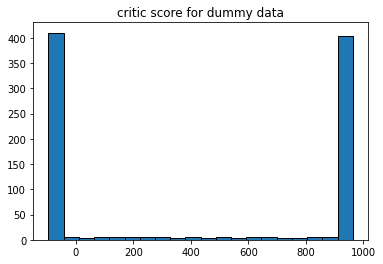

In [191]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.hist(context['critic'].flatten(), bins=20, edgecolor='black')
plt.title("critic score for dummy data");

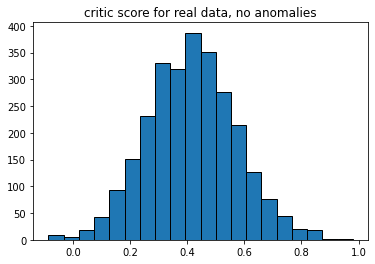

In [119]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.hist(context['critic'].flatten(), bins=20, edgecolor='black')
plt.title("critic score for real data, no anomalies");

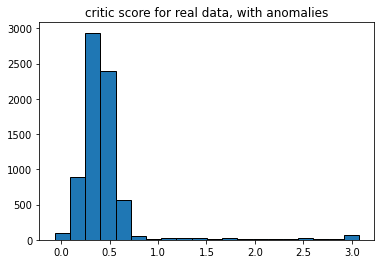

In [124]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.hist(context['critic'].flatten(), bins=20, edgecolor='black')
plt.title("critic score for real data, with anomalies");

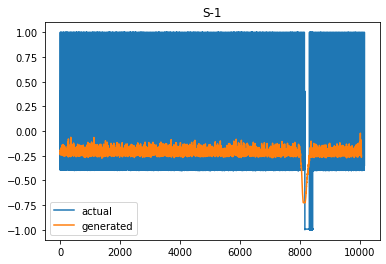

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(signal['value'], label='actual')
plt.plot(unroll_ts(context['y_hat']), label='generated')
plt.legend()
plt.title('S-1')
plt.savefig("tf1_s1.png", dpi=300);

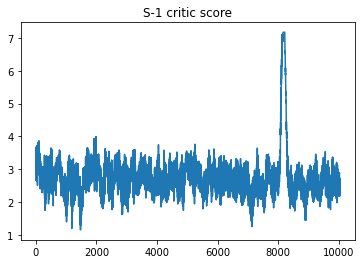

In [23]:
plt.title('S-1 critic score')
plt.plot(context['critic'])
plt.savefig("tf1_s1_critic.png", dpi=300);

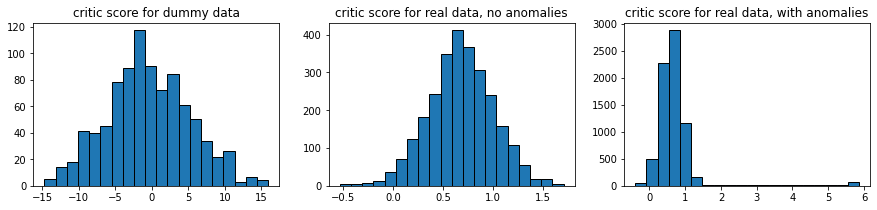

In [182]:
# 3 in 1 plot

plt.figure(figsize=(15, 3))
titles = ["critic score for dummy data",
          "critic score for real data, no anomalies",
          "critic score for real data, with anomalies"]

for i, item in enumerate(result):
    plt.subplot(1, 3, i+1)
    plt.hist(item['critic'].flatten(), bins=20, edgecolor='black')
    plt.title(titles[i])
    plt.savefig("scaled_data_-11.png", dpi=300);

## Result

The larger the critic output -> the more likely it is too be an anomaly